# Reproducibility Vignette for SyNBEATS

This vignette demonstrates our implementation of SyNBEATS for the simulated data. Below we first load the required packages and the necessary dependencies. The version and environment controls are available in the following link:

SyNBEATS repository: [`https://github.com/Crabtain959/SyNBEATS`](https://github.com/Crabtain959/SyNBEATS).

In [140]:
import numpy as np
import pandas as pd
import os
from SyNBEATS import SyNBEATS
from darts import TimeSeries
from darts.metrics import mae
from joblib import Parallel, delayed

User needs to maintain the home directory accordingly. The simulated data file `DGP0_Y_N64_T32_iter1.csv` contains the outcome matrix for $N = 64$, $T = 32$ and for the first replicate. The post treatment data has length $T/4$ and the pretreatment panel (before and including time $T$) is fully observed.

In [143]:
# Change the directory according to the home directory where you keep the folder
os.chdir(os.path.expanduser("~/Library/CloudStorage/Box-Box/Academics/Causal_TS/Code/data_files/DGP0/Y_files"))
filename = "DGP0_Y_N32_T32_iter1.csv"
Y = pd.read_csv(filename)
TT = int(filename.split("T")[1].split("_")[0])

# Reshape the panel
Y_train = Y.iloc[:, :TT + TT//4]
Y_long = Y_train.stack().reset_index()
Y_long.columns = ["id", "time", "Y_obs"]
Y_long["time"] = Y_long["time"].str.extract("V(\d+)").astype(int) - 1
Y_long.head

<bound method NDFrame.head of       id  time     Y_obs
0      0     0 -0.183168
1      0     1  0.023115
2      0     2  0.040135
3      0     3 -0.066891
4      0     4  0.335792
...   ..   ...       ...
1275  31    35  0.088766
1276  31    36 -0.226473
1277  31    37 -0.048007
1278  31    38  0.039677
1279  31    39  0.048135

[1280 rows x 3 columns]>

Now we run the model of SyNBEATS for a user 1. Since we don't have access to GPU we use CPU to train the model. 

In [144]:
model = SyNBEATS(Y_long, treat_ids = [1], target_time = TT, date_format = None)
model.train(use_gpu = 0, verbose=False)
predictions = model.predict(verbose=False)

Next we use the trained model to predict the 3 post treatment period for treated user. The plots capture the post treatment outcome trajectories and its departure from the observed outcome variables.

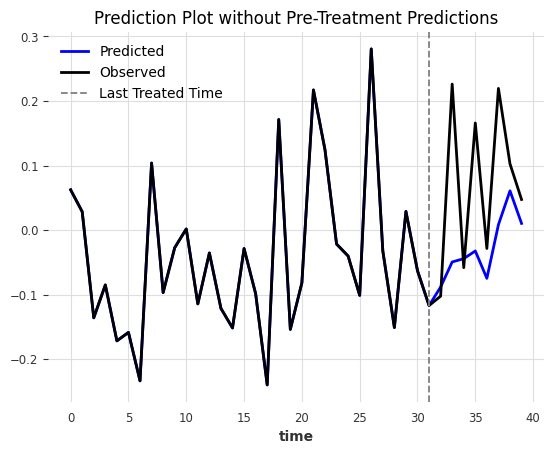

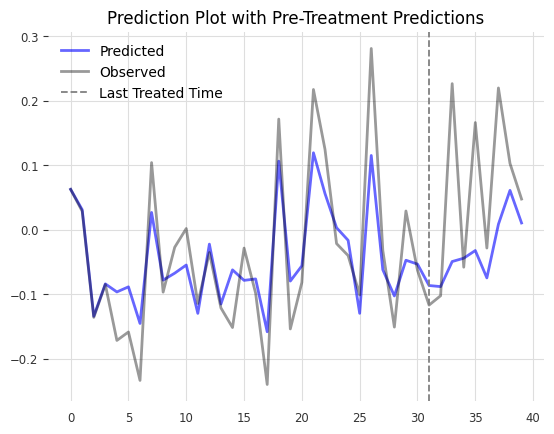

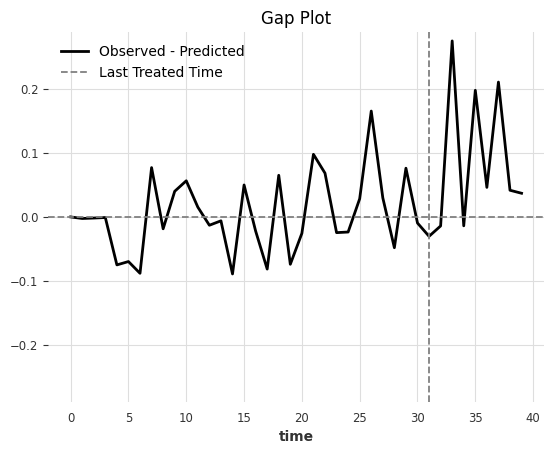

array([-0.08836923, -0.04951149, -0.04435527])

In [145]:
model.plot_predictions(predictions)
model.plot_predictions(predictions, predict_pretreatment = True)  
# by setting predict_pretreatment=True, you can visualize the pretreatment predictions
model.plot_gap()
predictions.values().flatten()[:3]

Now we generalize the operation for any fixed $N$ and $T$ for 30 trials. Since the code performs substantially slower than the benchmarks FOCUS and mSSA, we run ot fixing $N$ and $T$, and changing their values manually for keeping track of the outputs. The prediction function is implemented over 30 trials with 4 cores in parallel.

In [147]:
### User needs to change accordingly following the location of Y_files
os.chdir(os.path.expanduser("~/Library/CloudStorage/Box-Box/Academics/Causal_TS/Code/data_files/DGP0/Y_files"))

def process_file(N, TT, n):
    file_name = f"DGP0_Y_N{N}_T{TT}_iter{n}.csv"
    Y = pd.read_csv(file_name)
    Y.index.name = 'user'
    Y.columns.name = 'time'

    # Reshape to long
    Y_train = Y.iloc[:, :TT + TT//4]
    Y_long = Y_train.stack().reset_index()
    Y_long.columns = ["id", "time", "Y_obs"]
    Y_long["time"] = Y_long["time"].str.extract("V(\d+)").astype(int) - 1

    results = []
    for i in range(32):  # ids 0..31 for only first 32 users
        model = SyNBEATS(Y_long, treat_ids=[i], target_time=TT)
        model.train(use_gpu=0, verbose=False)
        predictions = model.predict(verbose=False)
        preds_first3 = np.array(list(predictions.values()))[:3].flatten()  # <- flatten
        results.append(preds_first3)
        print(f"Finished user {i} for file {n}", flush=True)

    # Convert to DataFrame (N x 3)
    df_out = pd.DataFrame(results, columns=["h1", "h2", "h3"])
    df_out.index.name = "id"

    # Save one folder up
    out_file = os.path.join(f"../synout_files/N{N}_T{TT}", f"synout_DGP0_Y_N{N}_T{TT}_iter{n}.csv")
    df_out.to_csv(out_file, index=True)
    print(f"Finished n={n}, saved: {out_file}", flush=True)  # <-- message from worker
    return df_out


Below we produce the outputs of the first 32 users and $T = 32$ time points. The forecasted panels across the 30 trials are saved as CSV files and later imported in R for the benchmark analysis. 

In [ ]:
from tqdm import tqdm
N = 64
TT = 32 
### range of TT : 32, 64, 128, 256.

os.makedirs(f"../synout_files/N{N}_T{TT}", exist_ok=True)

# run for n = 1,...,30
Parallel(n_jobs=4)(
    delayed(process_file)(N, TT, n) for n in tqdm(range(1, 31)) # change the range according to user requirement
)

 13%|█▎        | 4/30 [00:00<00:00, 34.48it/s]0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems t

Finished user 0 for file 2
Finished user 0 for file 3
Finished user 0 for file 4
Finished user 1 for file 2
Finished user 1 for file 3
Finished user 1 for file 4
Finished user 0 for file 1
Finished user 1 for file 1
Finished user 2 for file 4
Finished user 2 for file 3
Finished user 2 for file 2
Finished user 3 for file 4
Finished user 2 for file 1
Finished user 3 for file 2
Finished user 3 for file 3
Finished user 4 for file 4
Finished user 4 for file 2
Finished user 4 for file 3
Finished user 5 for file 4
Finished user 5 for file 2
Finished user 5 for file 3
Finished user 6 for file 4
Finished user 7 for file 4
Finished user 6 for file 2
Finished user 6 for file 3
Finished user 3 for file 1
Finished user 7 for file 2
Finished user 4 for file 1
Finished user 7 for file 3
Finished user 5 for file 1
Finished user 8 for file 2
Finished user 6 for file 1
Finished user 8 for file 4
Finished user 9 for file 2
Finished user 8 for file 3
Finished user 7 for file 1
Finished user 9 for file 4
F

 27%|██▋       | 8/30 [11:11<36:13, 98.78s/it]

Finished user 31 for file 4
Finished n=4, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter4.csv
Finished user 28 for file 2
Finished user 25 for file 1
Finished user 31 for file 3
Finished n=3, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter3.csv
Finished user 29 for file 2
Finished user 0 for file 5
Finished user 26 for file 1
Finished user 30 for file 2
Finished user 1 for file 5
Finished user 27 for file 1
Finished user 31 for file 2
Finished n=2, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter2.csv
Finished user 0 for file 6
Finished user 1 for file 6
Finished user 2 for file 5
Finished user 28 for file 1
Finished user 29 for file 1
Finished user 0 for file 7
Finished user 3 for file 5
Finished user 2 for file 6
Finished user 30 for file 1
Finished user 1 for file 7
Finished user 4 for file 5
Finished user 5 for file 5
Finished user 31 for file 1
Finished n=1, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter1.csv
Finished user 3 for file 6
Fini

 40%|████      | 12/30 [20:42<35:38, 118.78s/it]

Finished user 31 for file 5
Finished n=5, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter5.csv
Finished user 28 for file 6
Finished user 22 for file 8
Finished user 23 for file 7
Finished user 29 for file 6
Finished user 24 for file 7
Finished user 0 for file 9
Finished user 23 for file 8
Finished user 1 for file 9
Finished user 24 for file 8
Finished user 30 for file 6
Finished user 31 for file 6
Finished n=6, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter6.csv
Finished user 25 for file 7
Finished user 0 for file 10
Finished user 26 for file 7
Finished user 1 for file 10
Finished user 2 for file 9
Finished user 25 for file 8
Finished user 27 for file 7
Finished user 26 for file 8
Finished user 3 for file 9
Finished user 27 for file 8
Finished user 28 for file 7
Finished user 4 for file 9
Finished user 2 for file 10
Finished user 29 for file 7
Finished user 5 for file 9
Finished user 30 for file 7
Finished user 6 for file 9
Finished user 28 for file 8
Finished user

 53%|█████▎    | 16/30 [31:24<31:34, 135.32s/it]

Finished user 31 for file 10
Finished n=10, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter10.csv
Finished user 28 for file 9
Finished user 21 for file 12
Finished user 29 for file 9
Finished user 0 for file 13
Finished user 30 for file 9
Finished user 23 for file 11
Finished user 1 for file 13
Finished user 31 for file 9
Finished n=9, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter9.csv
Finished user 24 for file 11
Finished user 22 for file 12
Finished user 0 for file 14
Finished user 1 for file 14
Finished user 25 for file 11
Finished user 2 for file 13
Finished user 23 for file 12
Finished user 26 for file 11
Finished user 24 for file 12
Finished user 27 for file 11
Finished user 2 for file 14
Finished user 3 for file 13
Finished user 28 for file 11
Finished user 25 for file 12
Finished user 4 for file 13
Finished user 29 for file 11
Finished user 3 for file 14
Finished user 5 for file 13
Finished user 26 for file 12
Finished user 4 for file 14
Finished user 6 fo

 67%|██████▋   | 20/30 [42:21<24:17, 145.70s/it]

Finished user 31 for file 13
Finished n=13, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter13.csv
Finished user 24 for file 15
Finished user 22 for file 16
Finished user 27 for file 14
Finished user 25 for file 15
Finished user 0 for file 17
Finished user 23 for file 16
Finished user 26 for file 15
Finished user 1 for file 17
Finished user 28 for file 14
Finished user 27 for file 15
Finished user 29 for file 14
Finished user 24 for file 16
Finished user 28 for file 15
Finished user 2 for file 17
Finished user 29 for file 15
Finished user 30 for file 15
Finished user 30 for file 14
Finished user 25 for file 16
Finished user 31 for file 15
Finished n=15, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter15.csv
Finished user 31 for file 14
Finished n=14, saved: ../synout_files/N64_T32/synout_DGP0_Y_N64_T32_iter14.csv
Finished user 3 for file 17
Finished user 0 for file 19
Finished user 26 for file 16
Finished user 0 for file 18
Finished user 4 for file 17
Finished user 27